In [1]:
%%capture
!pip install -r requirements.txt

In [3]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
from tools.globals import load_country_globals
from tools.nnsight_utils import collect_residuals
from tools.patchscope import patch_scope_gen

from nnsight import LanguageModel
from transformers import AutoTokenizer

load_country_globals()

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [4]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

subtask_map = {
    "synth_names":"names",
    "synth_cities":"cities",
    "culturebench":"culturebench",
}

def eval_or_skip(txt):
    try:
        return eval(txt)
    except:
        return None

country_to_suffix= {"Turkey": "tr", "France": "fr", "Russia": "ru", "Bangladesh": "bn", "United States":"us"}

### Load Model

In [5]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
nnmodel = LanguageModel('/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b-it', 
                        device_map='cuda:0', 
                        dispatch=True, 
                        torch_dtype=t.bfloat16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### (Optional) Sample data for Patchscope

In [ ]:
all_data = pd.read_csv("model_gen/all_models_eval_subset.csv").query("model=='gemma2_9b_it'").copy()

all_data["input"] = all_data["input"].str.replace("1,2,3,4.", "1,2.")

all_data["subtask"] = all_data["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))
all_data["key"] = all_data["question_id"] + all_data["country"]

In [7]:
import re

def change_numbers(prompt):
    # Match the options in the form of "1. Option1\n2. Option2"
    pattern = r"\n1\.\s*(.*?)\n2\.\s*(.*?)(?=\n|$)"

    def change_match(match):
        option1, option2 = match.groups()
        return f"\nA. {option1}\nB. {option2}"

    # Substitute the matched pattern with swapped options
    swapped_prompt = re.sub(pattern, change_match, prompt)
    swapped_prompt = swapped_prompt.replace("1,2", "A,B")

    return swapped_prompt

In [ ]:
test_data = all_data.query("lang=='English' and hint==False and ans_type!='local'").copy()

test_data_list = []

for c in ["Turkey", "France", "Russia", "Bangladesh"]:#, "United States"]:
    for task in ["names", "cities", "culturedistil"]:
        task_data = test_data.query(f"subtask=='{task}' and country=='{c}'")
        task_data = task_data.sample(n=min(task_data.shape[0],50), random_state=42)
        test_data_list.append(task_data)

test_data = pd.concat(test_data_list).sort_values("key")

keys = set(test_data["key"].unique())
source_data = all_data.query("key in @keys and hint==False and lang!='English'").copy().sort_values("key")
test_data.shape

(600, 19)

In [24]:
# Implicit case
test_data = pd.read_csv("data/gemma2_9b_it_exp_patchscope.csv").sort_values("key")

keys = set(test_data["key"].unique())
source_data = all_data.query("key in @keys and hint==True and lang=='English'").copy().sort_values("key")

In [25]:
test_data["input_target"] = test_data["input"]
test_data["input_source"] = list(source_data["input"].apply(lambda x: change_numbers(x)))

In [27]:
test_data.to_csv("data/gemma2_9b_it_explicit_patchscope_data.csv", index=False)

### Run Experiments

In [ ]:
test_data = pd.read_csv("data/gemma2_9b_it_implicit_patchscope_data.csv")

In [ ]:
from tqdm import tqdm

filename = "patchscope/imp_patching.pkl"
batch_size = 32
countries = ["Turkey", "France", "Russia", "Bangladesh"]#, "United States"]


outputs = []
for country in countries:
    print(country)
    
    test_entries = test_data.query("country==@country").to_dict(orient="records")
    
    batch_entries = [test_entries[k:k+batch_size] for k in range(0, len(test_entries), batch_size)]
    batch_inputs = [[entry["input_target"] for entry in batch] for batch in batch_entries]

    batch_residuals = []
    for source_batch in batch_entries:
        with t.no_grad():
            res_batch = []
            for i,entry in enumerate(source_batch):
                imp = entry["input_source"]
                res_batch.append(collect_residuals(nnmodel, imp, calculate_probs=False)["residuals"][:,0,-1,:])
            res_batch = t.stack(res_batch, dim=1).unsqueeze(2)
            batch_residuals.append(res_batch)

    for i,batch_imp in tqdm(enumerate(batch_inputs), total=len(batch_inputs)):
        with t.no_grad():
            out = patch_scope_gen(nnmodel, tokenizer, batch_residuals[i], target_prompt=batch_imp, target_token_idx=-1, n_new_tokens=1)
            for j,layer in enumerate(out[0]):
                texts = out[0][layer]
                probs = out[1]
                epsilon = 1e-6
                probs[probs < epsilon] = 0
                for k, text in enumerate(texts):
                    out_dict = {"patch_out": text, "patch_prob": probs[j,:,k,:].to_sparse(), "layer": layer}
                    out_dict.update(batch_entries[i][k])
                    outputs.append(out_dict)

pd.to_pickle(outputs, filename)

Turkey


100%|██████████| 5/5 [01:15<00:00, 15.03s/it]


France


100%|██████████| 5/5 [01:22<00:00, 16.51s/it]


Russia


100%|██████████| 5/5 [01:15<00:00, 15.12s/it]


Bangladesh


100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


### Visualize results

In [ ]:
from tools.patchscope import get_patching_probs

outputs = pd.read_pickle("patchscope/imp_patching.pkl")
outputs_df = pd.DataFrame(outputs)
opt_to_str = lambda x: str(int(x))
outputs_df["ans_west"] = outputs_df["ans_west_idx"].apply(opt_to_str)
outputs_df["ans_local"] = outputs_df["ans_local_idx"].apply(opt_to_str)

outputs_df.dropna(subset=["ans_west", "ans_local"], inplace=True)

outputs_df = outputs_df.apply(lambda x: get_patching_probs(x, tokenizer, token_index=-1), axis=1)
outputs_df.dropna(subset=["prob_west", "prob_local"], inplace=True)
outputs_df.drop(columns=["patch_prob"], inplace=True)

(600, 42)


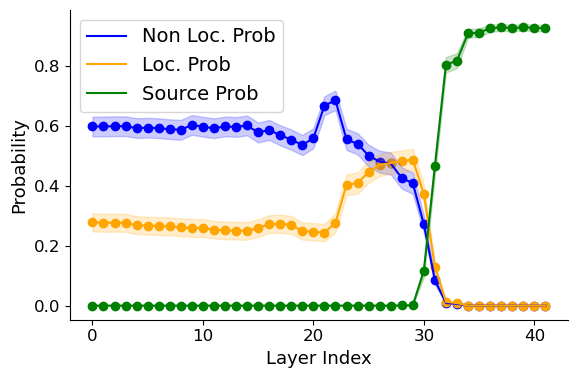

In [ ]:
from tools.patchscope import plot_avg_probs_ax
fig, ax = plot_avg_probs_ax(outputs_df.query("country!=''"), include_source=True)
fig.savefig("imp_patchscope_fixed_prompts.pdf", dpi=300, bbox_inches='tight')


In [ ]:
from tools.patchscope import get_patching_probs

outputs = pd.read_pickle("patchscope/exp_patching.pkl")
outputs_df = pd.DataFrame(outputs)
opt_to_str = lambda x: str(int(x))
outputs_df["ans_west"] = outputs_df["ans_west_idx"].apply(opt_to_str)
outputs_df["ans_local"] = outputs_df["ans_local_idx"].apply(opt_to_str)

outputs_df.dropna(subset=["ans_west", "ans_local"], inplace=True)

outputs_df = outputs_df.apply(lambda x: get_patching_probs(x, tokenizer, token_index=-1), axis=1)
outputs_df.dropna(subset=["prob_west", "prob_local"], inplace=True)
outputs_df.drop(columns=["patch_prob"], inplace=True)

(600, 42)


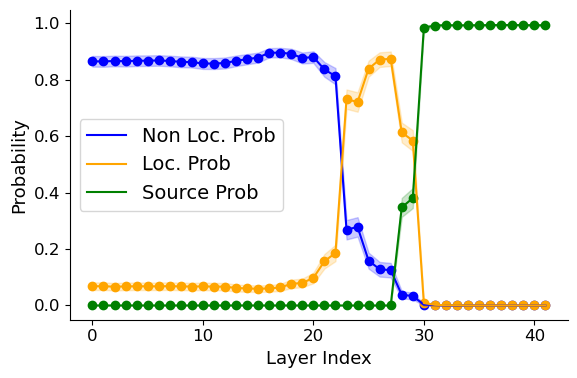

In [ ]:
from tools.patchscope import plot_avg_probs_ax
plot_avg_probs_ax(outputs_df.query("country!=''"), include_source=True)